In [1]:
""" ######## KOREAN FONT INSTALL FOR MATPLOTLIB ######## """
"""!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf"""

'!sudo apt-get install -y fonts-nanum\n!sudo fc-cache -fv\n!rm ~/.cache/matplotlib -rf'

In [2]:
""" ######## DATA SETTING ######## """
import matplotlib.pyplot as plt
import numpy as np

STOCK = 100; DAY = 248; MAXLEN = 50; COMP = 9 # Constant, COMP <= 10

cp = np.zeros((DAY,STOCK), dtype = 'float')
X = np.zeros((DAY,STOCK), dtype = 'float')
sum = np.zeros(DAY, dtype = 'float')

code = [[]*10]*STOCK
name = [[]*MAXLEN]*STOCK

In [3]:
""" ######## DATA READ ######## """
file1 = open('total_cp_list.txt','r')
file2 = open('total_list.txt',encoding='UTF-8')

for i in range(STOCK):
  line = file1.readline().rstrip().split(' ')
  for j in range(DAY):
    cp[j][i] = float(line[j])
  file1.readline()
    
  line = file2.readline().rstrip().split(' ')
  code[i], name[i] = line[0], line[1]
    
file1.close()
file2.close()

In [4]:
""" ######## 1. DATA PREPROCESSING : log2 ######## """
# Scaling by log2
for j in range(STOCK):
  for i in range(1,DAY):
    #X[i][j] = 100*(cp[i][j]/cp[i-1][j]-1)  # Daily difference method
    X[i][j] = np.log2(cp[i][j])-np.log2(cp[i-1][j])  # log2 method
    sum[i] += X[i][j]
  X[0][j] = 2*X[1][j]-X[2][j]  # Linear extrapolation day 0
  sum[0] += X[0][j]

In [5]:
""" ######## 2. APPLY PCA ######## """
X_bar = np.zeros((DAY,STOCK), dtype = 'float')
# Normalized(training) vector(X -> X bar)
for i in range(DAY):
  avg = sum[i]/STOCK
  X_bar[i,:] = X[i,:]-avg

# Compute eigens
cov = np.cov(X_bar)  # Covariance matrix : cov = x*x^T (DAY*DAY)
eigen_value, eigen_vector = np.linalg.eig(cov)

# Compute representative(feature) vector
rep = np.zeros((COMP,STOCK))  # Representative vector
for i in range(COMP):
  for j in range(STOCK):
    rep[i][j] = eigen_vector[:,i].dot(X_bar[:,j])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


In [6]:
""" ######## 3. K-means clustering ######## """
# Find min & max
min = np.zeros(COMP)
max = np.zeros(COMP)
for i in range(COMP):
  min[i] = np.amin(rep[i])
  max[i] = np.amax(rep[i])

# First center feature vector
f_vector = np.zeros((COMP,1<<COMP))
for i in range(1<<COMP):
  for j in range(COMP):
    f_vector[j][i] = min[j]+(max[j]-min[j])*(0.75 if (i&(1<<j))!=0 else 0.25)

# First cluster
cluster = np.zeros(STOCK, dtype="int")
count = np.zeros(1<<COMP, dtype="int")
center = np.zeros((COMP,1<<COMP))
for i in range(STOCK):
  min = 1e9
  idx = 0

  for j in range(1<<COMP):
    diff = 0
    # Root mean square
    for k in range(COMP):
      diff += (rep[k][i]-f_vector[k][j])**2
    diff = np.sqrt(diff)

    # Find nearest vector
    if(min > diff):
      min = diff
      idx = j

  # Clustering
  cluster[i] = idx
  count[idx] += 1
  center[:,idx] += rep[:,i]

# Iteration
for iter in range(15 if 8<COMP else 20-COMP):
  # Update center feature vectors
  for i in range(1<<COMP):
    f_vector[:,i] = center[:,i]/count[i] if count[i]>0 else f_vector[:,i]
  center[:,:] = 0
  count[:] = 0

  # Cluster update
  for i in range(STOCK):
    min = 1e30
    idx = 0

    for j in range(1<<COMP):
      diff = 0
      # Root mean square
      for k in range(COMP):
        diff += (rep[k][i]-f_vector[k][j])**2
      diff = np.sqrt(diff)

      # Find nearest vector
      if(min > diff):
        min = diff
        idx = j

    # Clustering
    cluster[i] = idx
    count[idx] += 1
    center[:,idx] += rep[:,i]

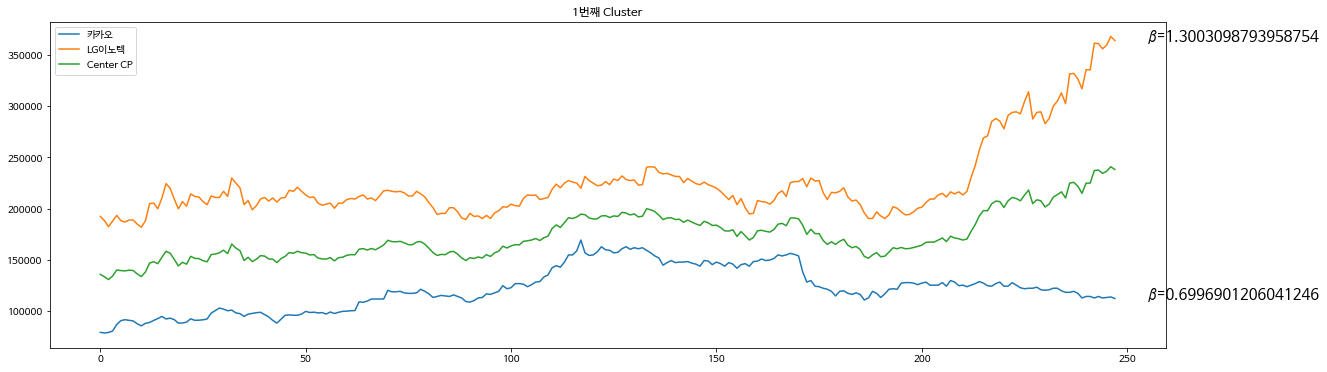

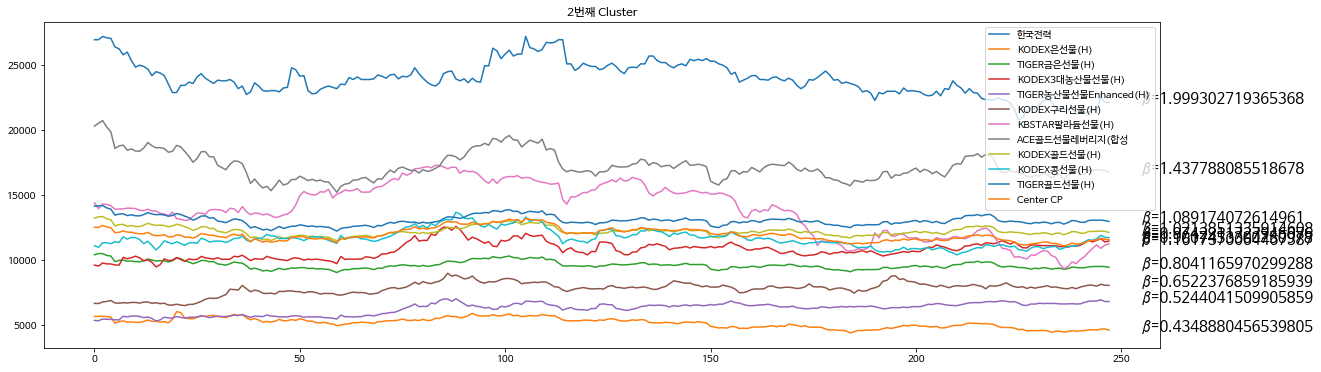

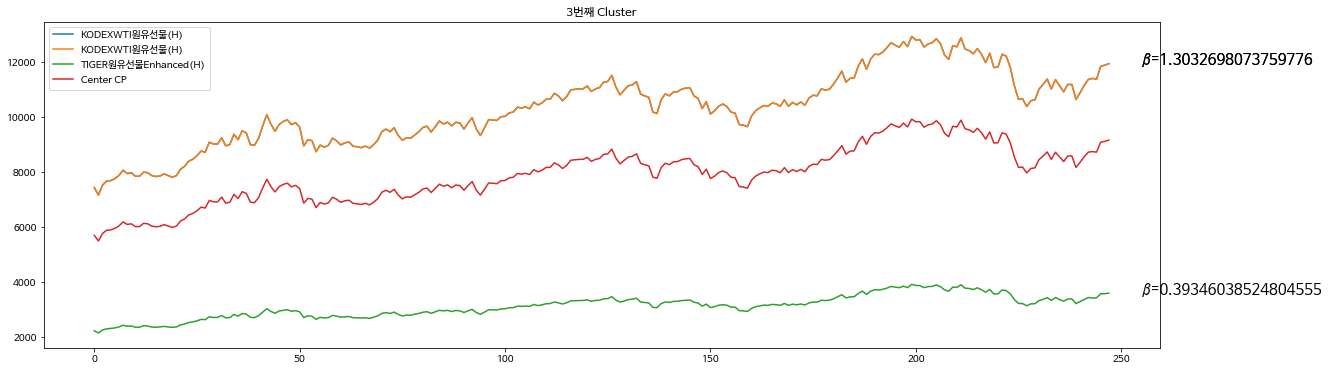

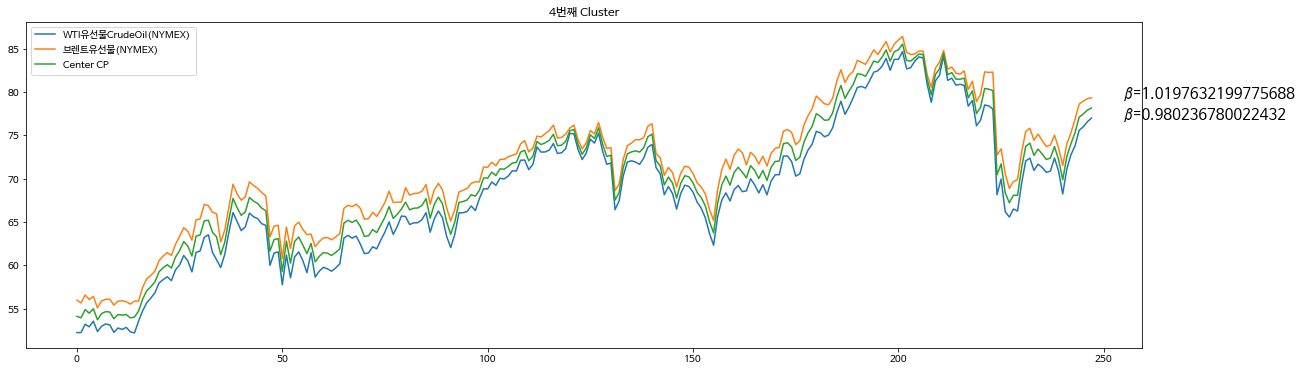

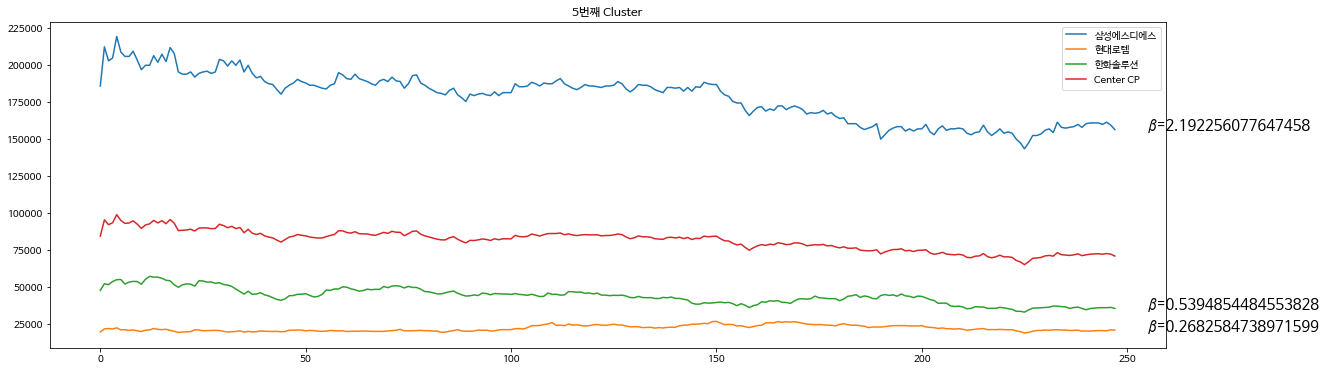

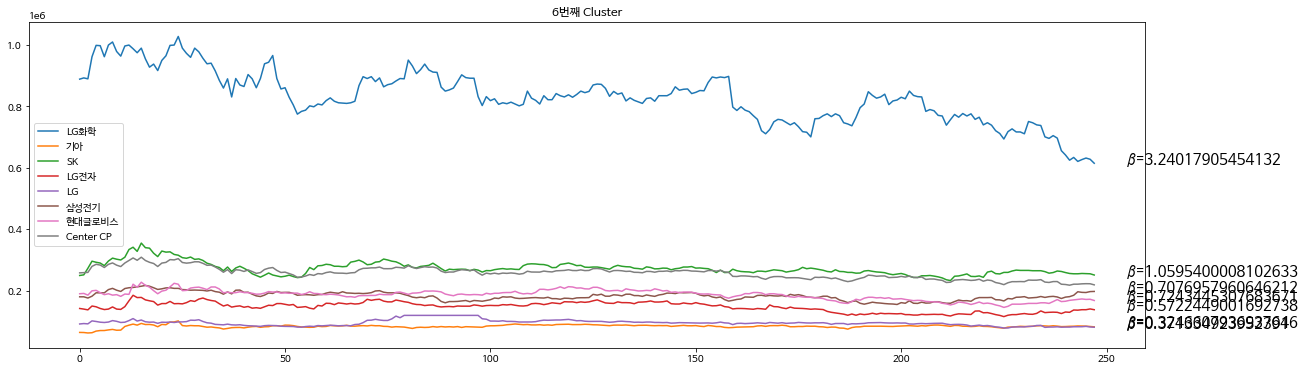

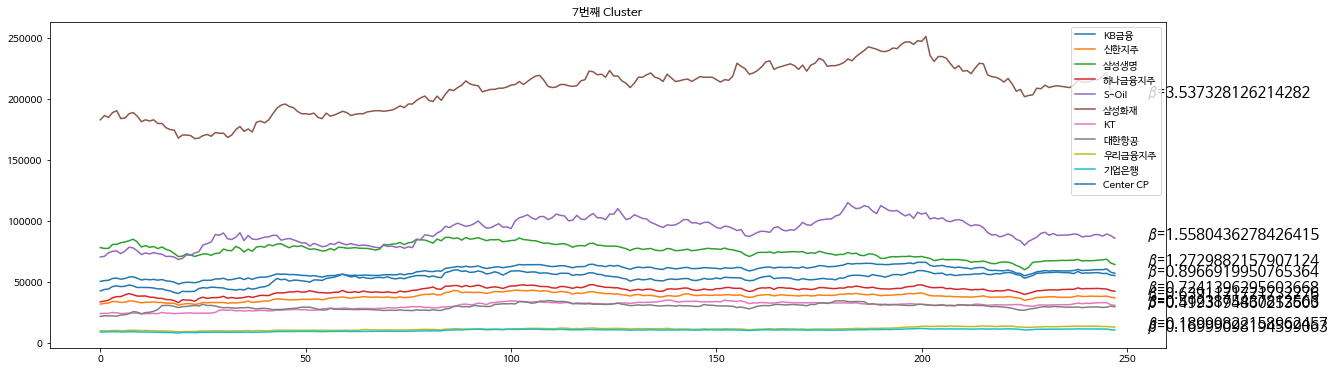

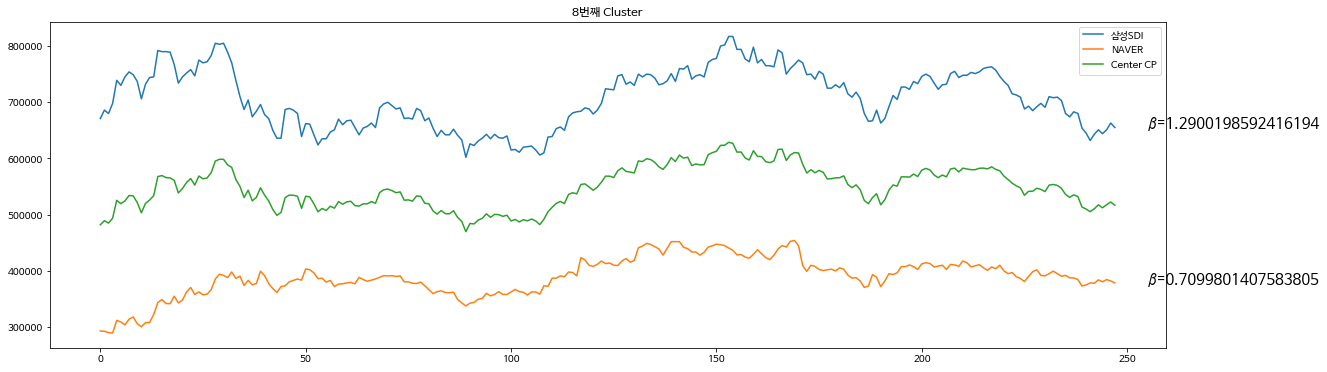

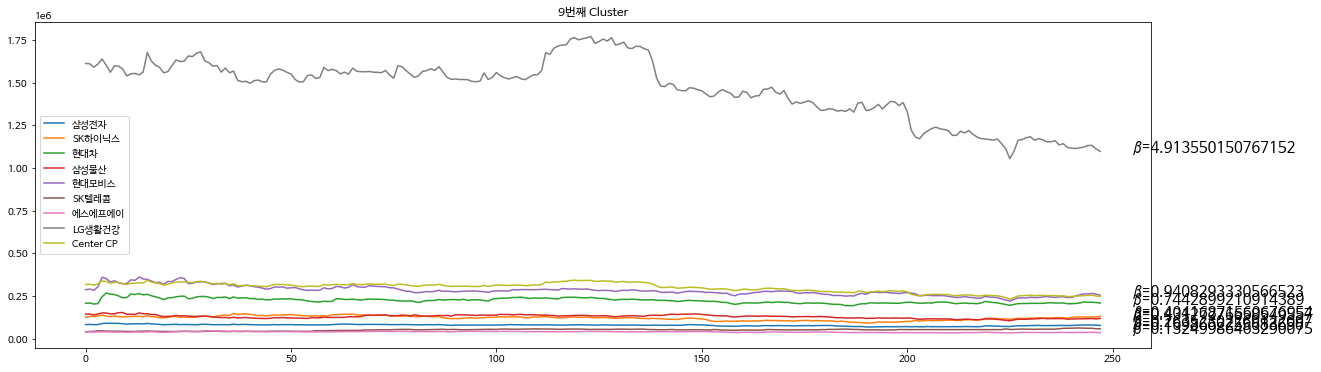

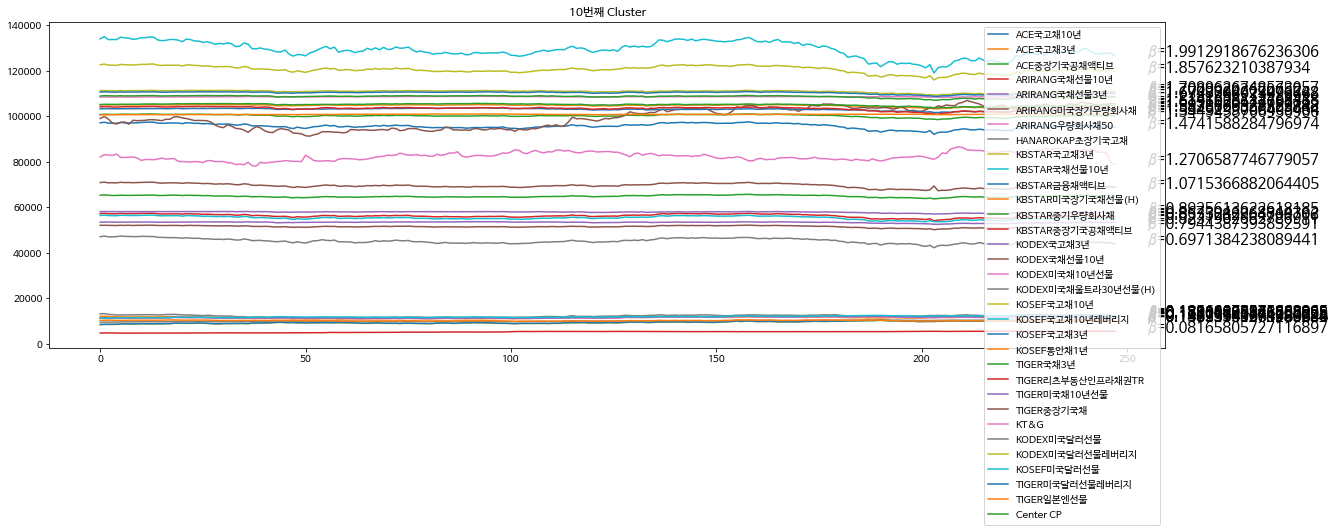

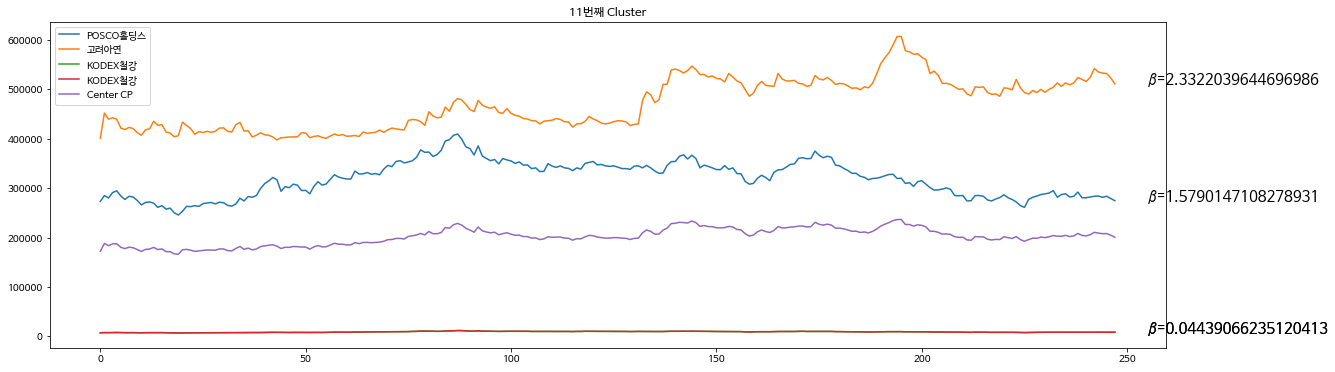

In [13]:
""" ######## 4. CLUSTER CENTER CP & β RATE ######## """
plt.rc('font', family='NanumBarunGothic')   # For Korean text
plt.rcParams['axes.unicode_minus'] = False  # For minus in axis

# Calculate CCP
CCP = np.zeros((DAY,1<<COMP))
for i in range(STOCK):
  for j in range(DAY):
    CCP[j][cluster[i]] += cp[j][i]  # Sum closing price
for i in range(1<<COMP):
  if(count[i]>0):
    for j in range(DAY):
      CCP[j][i] /= count[i] # Center(avg) = sum/count

# Calculate var(CCP)
var = np.zeros(1<<COMP)
for i in range(1<<COMP):
  var[i] = CCP[:,i].dot(CCP[:,i]) # Inner product

# Calcualte β RATE & visualization
cl_count = 0
beta = np.zeros(STOCK)
for i in range(1<<COMP):
  if(count[i]>1):   # A cluster with two or more stocks only
    plt.figure(figsize=(20,6))
    cl_count += 1
    for j in range(STOCK):
      if(cluster[j] == i):
        beta[j] = CCP[:,i].dot(cp[:,j])/var[i] # Get β RATE of one stock
        plt.plot(cp[:,j], label=name[j])
        plt.text(255,cp[DAY-1][j],'β='+str(beta[j]),fontsize=15)

    # Visualization
    plt.plot(CCP[:,i], label="Center CP")
    plt.title("%d번째 Cluster" % cl_count)
    
    plt.legend()
    plt.show()

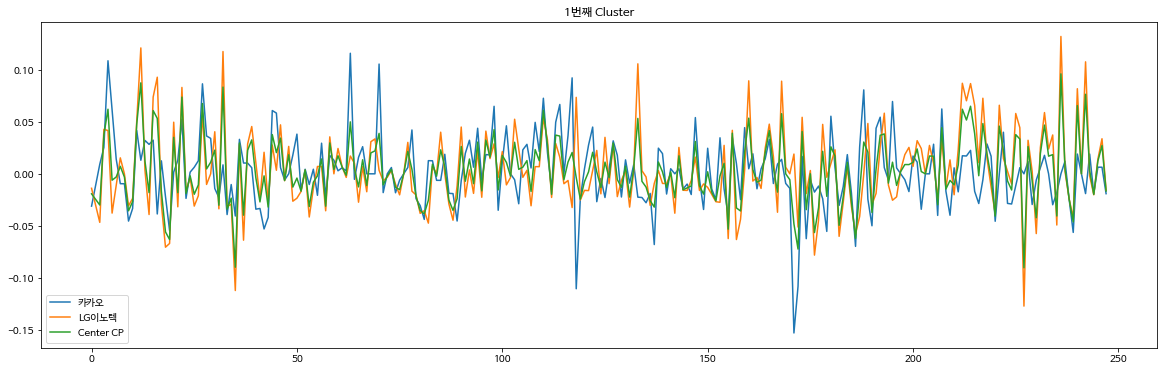

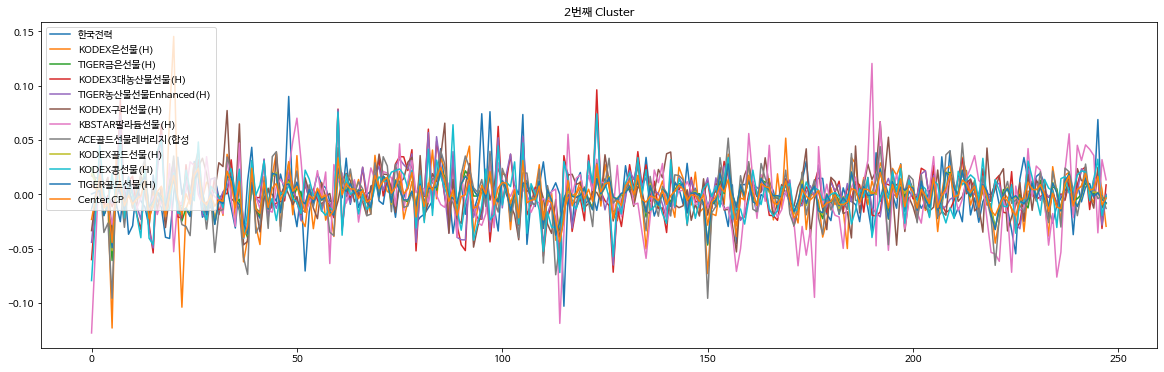

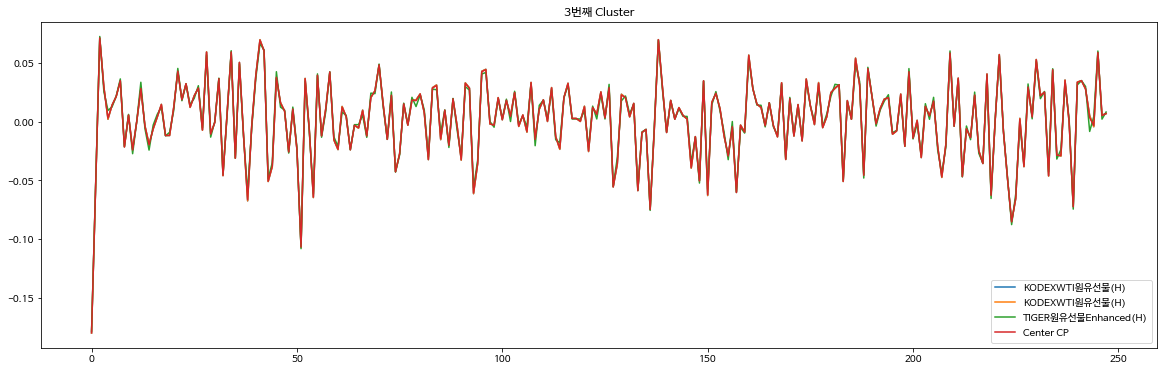

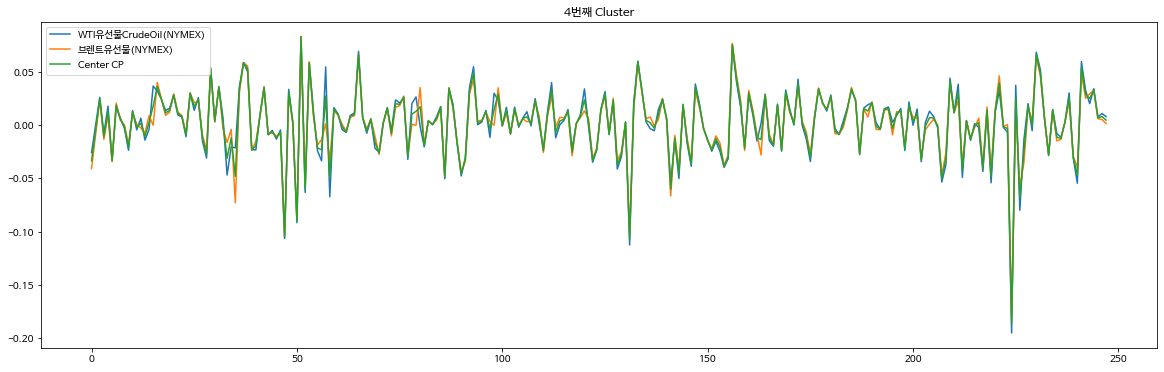

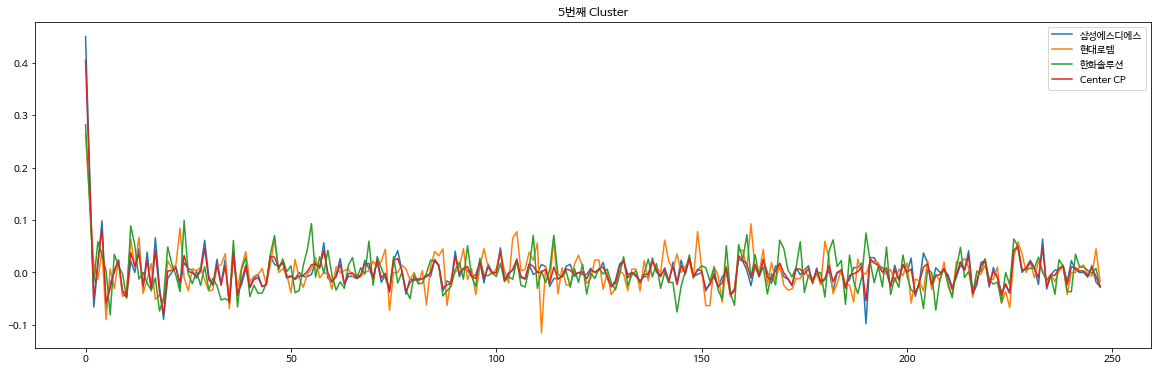

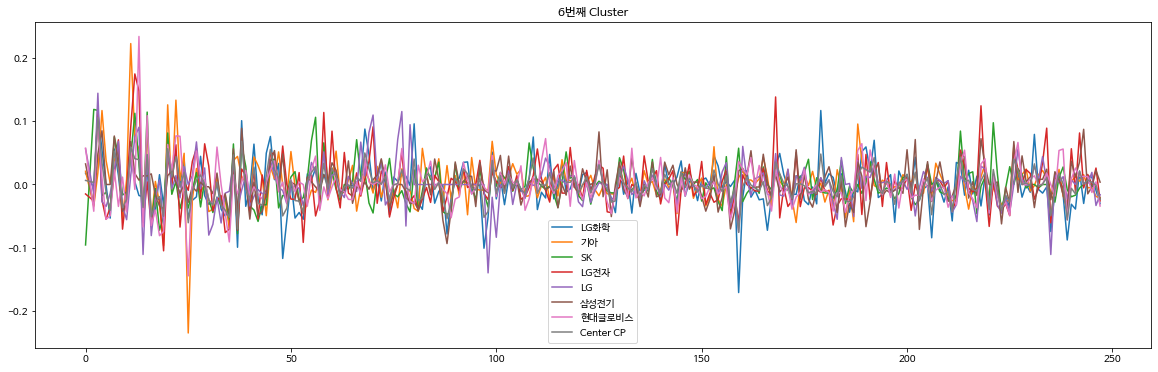

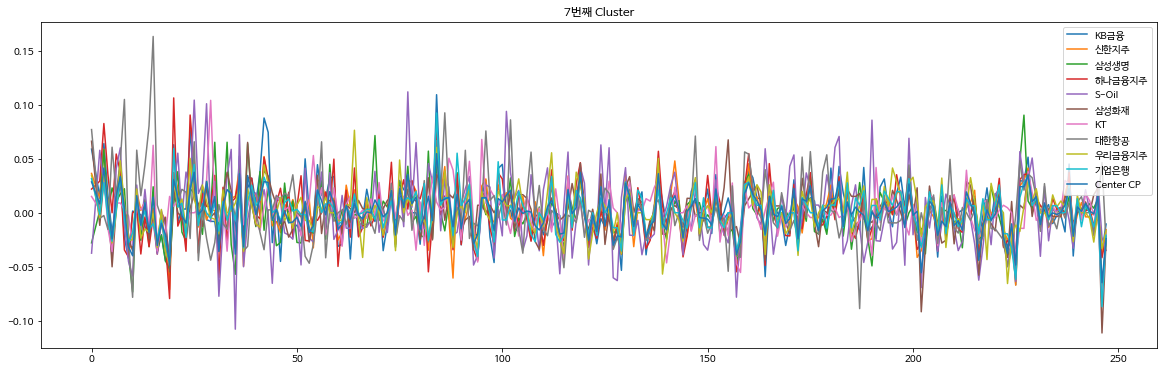

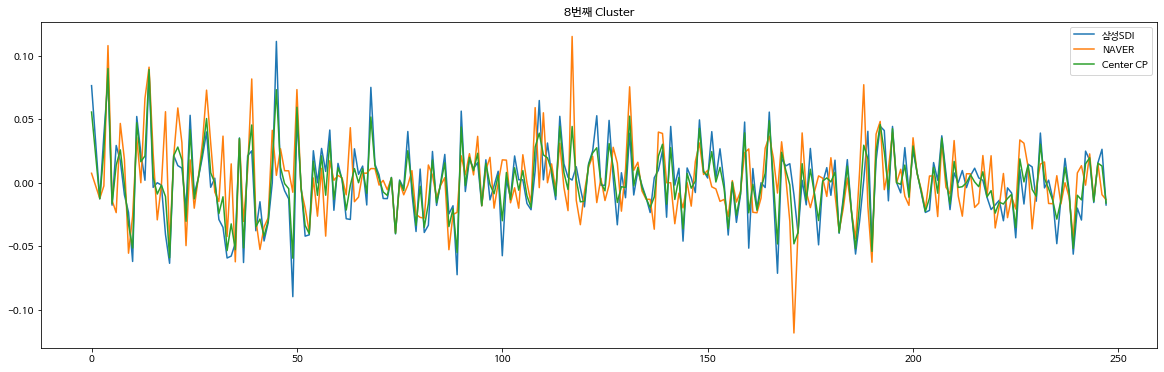

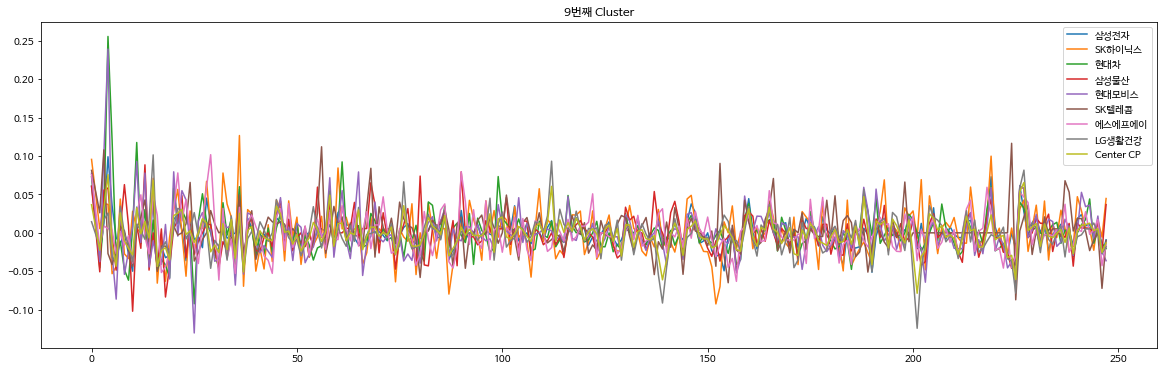

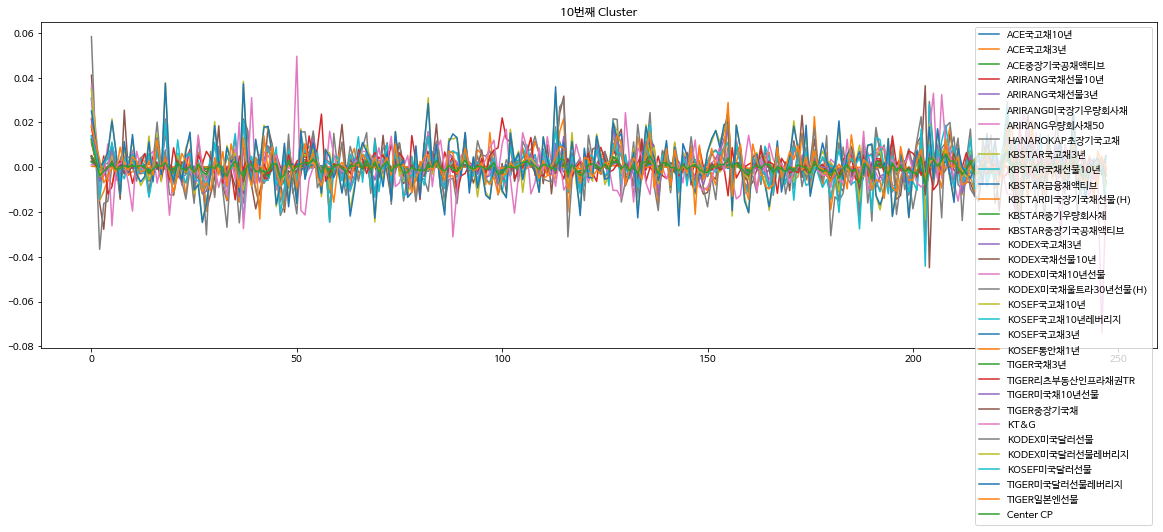

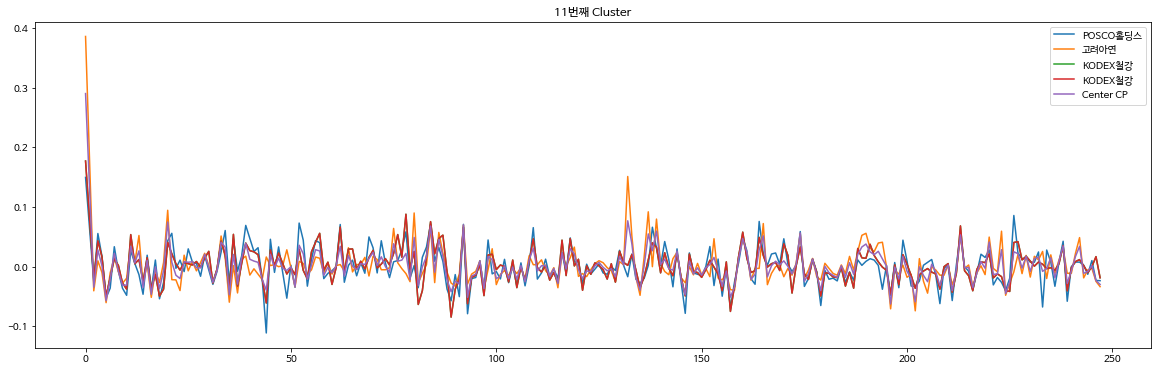

In [14]:
""" ######## 5. NORMALIZE ######## """
# Normalization using log2 & visualization
cl_count = 0
for i in range(1<<COMP):
  if(count[i]>1):   # A cluster with two or more stocks only
    plt.figure(figsize=(20,6))
    cl_count += 1
    normalize = np.zeros(DAY)
    for j in range(STOCK):
      if(cluster[j] == i):
        plt.plot(X[:,j], label=name[j])
    normalize[1:] = np.log2(CCP[1:,i]/CCP[0:DAY-1,i])  # log2 method
    normalize[0] = 2*normalize[1]-normalize[2]

    # Visualization
    plt.plot(normalize, label="Center CP")
    plt.title("%d번째 Cluster" % cl_count)
    
    plt.legend()
    plt.show()